# Harmful Content Detection - Dataset Deep Dive

**Understanding the Facebook Harmeme conversation-based dataset structure**

## Key Discovery: Dataset Format
- **8,500 training samples, 500 test samples** ✅ Great size for T4 GPU
- **Conversation-based format** - Each sample contains dialogues
- **Image + Text multimodal** - Perfect for your project scope
- **Clean data** - No missing values

## 1. Import Libraries and Load Data

In [0]:
# %pip install datasets --upgrade

In [0]:
dbutils.library.restartPython()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter
import json
import re
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading Facebook Harmeme dataset from HuggingFace...")
ds = load_dataset("George511242/Facebook_harmeme_dataset")
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

print("✅ Dataset loaded successfully!")
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Loading Facebook Harmeme dataset from HuggingFace...
✅ Dataset loaded successfully!
Train samples: 8500
Test samples: 500


In [0]:
print(train_df.head(10))

                                               image  ...                                      conversations
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
5  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
6  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
7  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...  ...  [{'from': 'human', 'value': 'A direct or indir...
8  {'bytes': b'\x89

In [0]:
display(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'conversations'],
        num_rows: 8500
    })
    test: Dataset({
        features: ['image', 'id', 'conversations'],
        num_rows: 500
    })
})

## 2. Understanding the Conversation Structure

In [0]:
def extract_meme_data(conversations_series):
    """
    Extract meme text and labels from conversation format
    
    Expected format:
    - Human: "...The text in the meme is: [MEME_TEXT]. Is this meme harmful? Options: Yes, No."
    - GPT: "Yes" or "No"
    """
    meme_texts = []
    labels = []
    raw_conversations = []
    
    for i, conv in enumerate(conversations_series):
        try:
            # Handle numpy array conversion
            if isinstance(conv, np.ndarray):
                conv = conv.tolist()
            
            # Extract human message and GPT response
            human_msg = None
            gpt_response = None
            
            for turn in conv:
                if turn['from'] == 'human':
                    human_msg = turn['value']
                elif turn['from'] == 'gpt':
                    gpt_response = turn['value']
            
            # Extract meme text using regex
            meme_text = None
            if human_msg:
                # Look for pattern: "The text in the meme is: [TEXT]"
                pattern = r"The text in the meme is: (.+?)\n"
                match = re.search(pattern, human_msg, re.DOTALL)
                if match:
                    meme_text = match.group(1).strip()
                else:
                    # Fallback: look for text after "is:"
                    pattern2 = r"is: (.+?)(?:\n|$)"
                    match2 = re.search(pattern2, human_msg)
                    if match2:
                        meme_text = match2.group(1).strip()
            
            # Extract label
            label = None
            if gpt_response:
                if gpt_response.strip().lower() == 'yes':
                    label = 1  # Harmful
                elif gpt_response.strip().lower() == 'no':
                    label = 0  # Not harmful
            
            meme_texts.append(meme_text)
            labels.append(label)
            raw_conversations.append({'human': human_msg, 'gpt': gpt_response})
            
        except Exception as e:
            print(f"Error processing conversation {i}: {e}")
            meme_texts.append(None)
            labels.append(None)
            raw_conversations.append(None)
    
    return meme_texts, labels, raw_conversations

# Extract data from training set
print("Extracting meme texts and labels from training data...")
train_meme_texts, train_labels, train_raw = extract_meme_data(train_df['conversations'])

print(f"✅ Extracted {len([t for t in train_meme_texts if t is not None])} meme texts")
print(f"✅ Extracted {len([l for l in train_labels if l is not None])} labels")

# Extract data from test set
print("\nExtracting meme texts and labels from test data...")
test_meme_texts, test_labels, test_raw = extract_meme_data(test_df['conversations'])

print(f"✅ Extracted {len([t for t in test_meme_texts if t is not None])} test meme texts")
print(f"✅ Extracted {len([l for l in test_labels if l is not None])} test labels")

Extracting meme texts and labels from training data...
✅ Extracted 8500 meme texts
✅ Extracted 8500 labels

Extracting meme texts and labels from test data...
✅ Extracted 500 test meme texts
✅ Extracted 500 test labels


## 3. Data Quality Check & Samples

In [0]:
# Check extraction quality
print("="*60)
print("EXTRACTION QUALITY CHECK")
print("="*60)

# Count successful extractions
train_valid_texts = [t for t in train_meme_texts if t is not None and len(t) > 0]
train_valid_labels = [l for l in train_labels if l is not None]

print(f"Training data:")
print(f"  • Total samples: {len(train_df)}")
print(f"  • Successfully extracted texts: {len(train_valid_texts)} ({len(train_valid_texts)/len(train_df)*100:.1f}%)")
print(f"  • Successfully extracted labels: {len(train_valid_labels)} ({len(train_valid_labels)/len(train_df)*100:.1f}%)")

test_valid_texts = [t for t in test_meme_texts if t is not None and len(t) > 0]
test_valid_labels = [l for l in test_labels if l is not None]

print(f"\nTest data:")
print(f"  • Total samples: {len(test_df)}")
print(f"  • Successfully extracted texts: {len(test_valid_texts)} ({len(test_valid_texts)/len(test_df)*100:.1f}%)")
print(f"  • Successfully extracted labels: {len(test_valid_labels)} ({len(test_valid_labels)/len(test_df)*100:.1f}%)")

# Show sample extractions
print(f"\n" + "="*60)
print("SAMPLE MEME TEXTS AND LABELS")
print("="*60)

for i in range(min(5, len(train_valid_texts))):
    idx = [j for j, t in enumerate(train_meme_texts) if t is not None][i]
    print(f"\n--- Sample {i+1} ---")
    print(f"Meme Text: '{train_meme_texts[idx]}'")
    print(f"Label: {train_labels[idx]} ({'Harmful' if train_labels[idx] == 1 else 'Not Harmful'})")
    print(f"ID: {train_df['id'].iloc[idx]}")

EXTRACTION QUALITY CHECK
Training data:
  • Total samples: 8500
  • Successfully extracted texts: 8500 (100.0%)
  • Successfully extracted labels: 8500 (100.0%)

Test data:
  • Total samples: 500
  • Successfully extracted texts: 500 (100.0%)
  • Successfully extracted labels: 500 (100.0%)

SAMPLE MEME TEXTS AND LABELS

--- Sample 1 ---
Meme Text: 'when you're feeling horny asf but your habibi is on periods let's try a goat.'
Label: 1 (Harmful)
ID: 1235

--- Sample 2 ---
Meme Text: 'meanwhile at the isis strip club.'
Label: 0 (Not Harmful)
ID: 1236

--- Sample 3 ---
Meme Text: 'when your human says "who' s a good girl?" and you already know it's you.'
Label: 0 (Not Harmful)
ID: 1243

--- Sample 4 ---
Meme Text: 'and that was the last nativity play my son was invited to take part in.'
Label: 1 (Harmful)
ID: 1245

--- Sample 5 ---
Meme Text: 'you can't be racist if there is no other race.'
Label: 1 (Harmful)
ID: 1247


## 4.  Label Distribution Analysis

LABEL DISTRIBUTION ANALYSIS
Training set label distribution:
0    5450
1    3050
dtype: int64
  Not Harmful (class 0): 5450 samples (64.1%)
  Harmful (class 1): 3050 samples (35.9%)

Test set label distribution:
0    250
1    250
dtype: int64


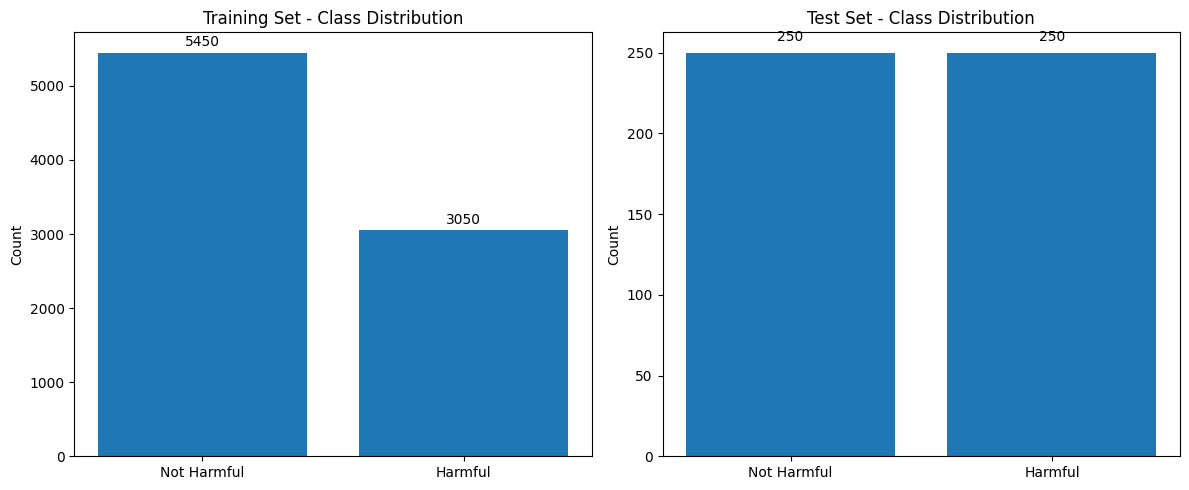

In [0]:
# Analyze label distribution
print("="*60)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*60)

# Clean labels for analysis
clean_train_labels = [l for l in train_labels if l is not None]
clean_test_labels = [l for l in test_labels if l is not None]

print("Training set label distribution:")
train_label_counts = pd.Series(clean_train_labels).value_counts().sort_index()
print(train_label_counts)

for label, count in train_label_counts.items():
    percentage = (count / len(clean_train_labels)) * 100
    label_name = "Harmful" if label == 1 else "Not Harmful"
    print(f"  {label_name} (class {label}): {count} samples ({percentage:.1f}%)")

if clean_test_labels:
    print("\nTest set label distribution:")
    test_label_counts = pd.Series(clean_test_labels).value_counts().sort_index()
    print(test_label_counts)

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
labels_names = ['Not Harmful', 'Harmful']
plt.bar(labels_names, [train_label_counts.get(0, 0), train_label_counts.get(1, 0)])
plt.title('Training Set - Class Distribution')
plt.ylabel('Count')
for i, v in enumerate([train_label_counts.get(0, 0), train_label_counts.get(1, 0)]):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

if clean_test_labels:
    plt.subplot(1, 2, 2)
    plt.bar(labels_names, [test_label_counts.get(0, 0), test_label_counts.get(1, 0)])
    plt.title('Test Set - Class Distribution')
    plt.ylabel('Count')
    for i, v in enumerate([test_label_counts.get(0, 0), test_label_counts.get(1, 0)]):
        plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Text Analysis

In [0]:
print("="*60)
print("MEME TEXT ANALYSIS - YOUR FOCUS AREA")
print("="*60)

# Analyze the extracted meme texts
valid_texts = [t for t in train_meme_texts if t is not None and len(t) > 0]

if valid_texts:
    # Text length statistics
    text_lengths = [len(text) for text in valid_texts]
    word_counts = [len(text.split()) for text in valid_texts]
    
    print(f"📊 TEXT LENGTH STATISTICS:")
    print(f"  • Total meme texts: {len(valid_texts)}")
    print(f"  • Average length: {np.mean(text_lengths):.1f} characters")
    print(f"  • Median length: {np.median(text_lengths):.1f} characters")
    print(f"  • Max length: {max(text_lengths)} characters")
    print(f"  • Min length: {min(text_lengths)} characters")
    print(f"  • Std deviation: {np.std(text_lengths):.1f}")
    
    print(f"\n📝 WORD COUNT STATISTICS:")
    print(f"  • Average words: {np.mean(word_counts):.1f}")
    print(f"  • Median words: {np.median(word_counts):.1f}")
    print(f"  • Max words: {max(word_counts)}")
    print(f"  • Min words: {min(word_counts)}")
    
    # Analyze by harmfulness
    harmful_texts = [train_meme_texts[i] for i, label in enumerate(train_labels) 
                    if label == 1 and train_meme_texts[i] is not None]
    safe_texts = [train_meme_texts[i] for i, label in enumerate(train_labels) 
                 if label == 0 and train_meme_texts[i] is not None]
    
    print(f"\n🔍 CONTENT ANALYSIS BY CLASS:")
    print(f"  • Harmful memes: {len(harmful_texts)} samples")
    print(f"  • Safe memes: {len(safe_texts)} samples")
    
    if harmful_texts:
        harmful_lengths = [len(text) for text in harmful_texts]
        print(f"  • Harmful avg length: {np.mean(harmful_lengths):.1f} chars")
    
    if safe_texts:
        safe_lengths = [len(text) for text in safe_texts]
        print(f"  • Safe avg length: {np.mean(safe_lengths):.1f} chars")


MEME TEXT ANALYSIS - YOUR FOCUS AREA
📊 TEXT LENGTH STATISTICS:
  • Total meme texts: 8500
  • Average length: 63.1 characters
  • Median length: 55.0 characters
  • Max length: 434 characters
  • Min length: 5 characters
  • Std deviation: 37.0

📝 WORD COUNT STATISTICS:
  • Average words: 11.7
  • Median words: 10.0
  • Max words: 70
  • Min words: 1

🔍 CONTENT ANALYSIS BY CLASS:
  • Harmful memes: 3050 samples
  • Safe memes: 5450 samples
  • Harmful avg length: 69.5 chars
  • Safe avg length: 59.5 chars


## 6. Sample Harmful vs Safe Memes

In [0]:
print("="*60)
print("SAMPLE HARMFUL vs SAFE MEMES")
print("="*60)

# Show examples of harmful memes
print("🚨 HARMFUL MEMES (Class 1):")
harmful_samples = [(train_meme_texts[i], i) for i, label in enumerate(train_labels) 
                  if label == 1 and train_meme_texts[i] is not None]

for i, (text, idx) in enumerate(harmful_samples[:3]):
    print(f"\n  {i+1}. '{text}' (ID: {train_df['id'].iloc[idx]})")

print(f"\n" + "="*40)
print("✅ SAFE MEMES (Class 0):")
safe_samples = [(train_meme_texts[i], i) for i, label in enumerate(train_labels) 
               if label == 0 and train_meme_texts[i] is not None]

for i, (text, idx) in enumerate(safe_samples[:3]):
    print(f"\n  {i+1}. '{text}' (ID: {train_df['id'].iloc[idx]})")

SAMPLE HARMFUL vs SAFE MEMES
🚨 HARMFUL MEMES (Class 1):

  1. 'when you're feeling horny asf but your habibi is on periods let's try a goat.' (ID: 1235)

  2. 'and that was the last nativity play my son was invited to take part in.' (ID: 1245)

  3. 'you can't be racist if there is no other race.' (ID: 1247)

✅ SAFE MEMES (Class 0):

  1. 'meanwhile at the isis strip club.' (ID: 1236)

  2. 'when your human says "who' s a good girl?" and you already know it's you.' (ID: 1243)

  3. 'ladies! if your man is offended by this he is a faggot. end of story.' (ID: 1258)


## 7. Text Preprocessing Insights

In [0]:
# Analyze text characteristics for preprocessing planning
print("="*60)
print("TEXT PREPROCESSING INSIGHTS")
print("="*60)

if valid_texts:
    # Character analysis
    all_text = ' '.join(valid_texts[:1000])  # Sample for performance
    
    # Special characters and patterns
    special_chars = set(re.findall(r'[^\w\s]', all_text))
    print(f"🔤 SPECIAL CHARACTERS FOUND:")
    print(f"  • Count: {len(special_chars)}")
    print(f"  • Characters: {sorted(special_chars)}")
    
    # Common patterns
    print(f"\n🔍 TEXT PATTERNS:")
    has_numbers = sum(1 for text in valid_texts[:100] if re.search(r'\d', text))
    has_urls = sum(1 for text in valid_texts[:100] if re.search(r'http[s]?://', text))
    has_mentions = sum(1 for text in valid_texts[:100] if re.search(r'@\w+', text))
    has_hashtags = sum(1 for text in valid_texts[:100] if re.search(r'#\w+', text))
    
    print(f"  • Texts with numbers: {has_numbers}/100")
    print(f"  • Texts with URLs: {has_urls}/100")
    print(f"  • Texts with mentions: {has_mentions}/100")
    print(f"  • Texts with hashtags: {has_hashtags}/100")
    
    # Case analysis
    all_upper = sum(1 for text in valid_texts[:100] if text.isupper())
    all_lower = sum(1 for text in valid_texts[:100] if text.islower())
    mixed_case = 100 - all_upper - all_lower
    
    print(f"\n📝 CASE DISTRIBUTION (sample of 100):")
    print(f"  • All uppercase: {all_upper}")
    print(f"  • All lowercase: {all_lower}")
    print(f"  • Mixed case: {mixed_case}")


TEXT PREPROCESSING INSIGHTS
🔤 SPECIAL CHARACTERS FOUND:
  • Count: 21
  • Characters: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '?', '~']

🔍 TEXT PATTERNS:
  • Texts with numbers: 6/100
  • Texts with URLs: 0/100
  • Texts with mentions: 0/100
  • Texts with hashtags: 0/100

📝 CASE DISTRIBUTION (sample of 100):
  • All uppercase: 0
  • All lowercase: 100
  • Mixed case: 0


## 8.Visualizations

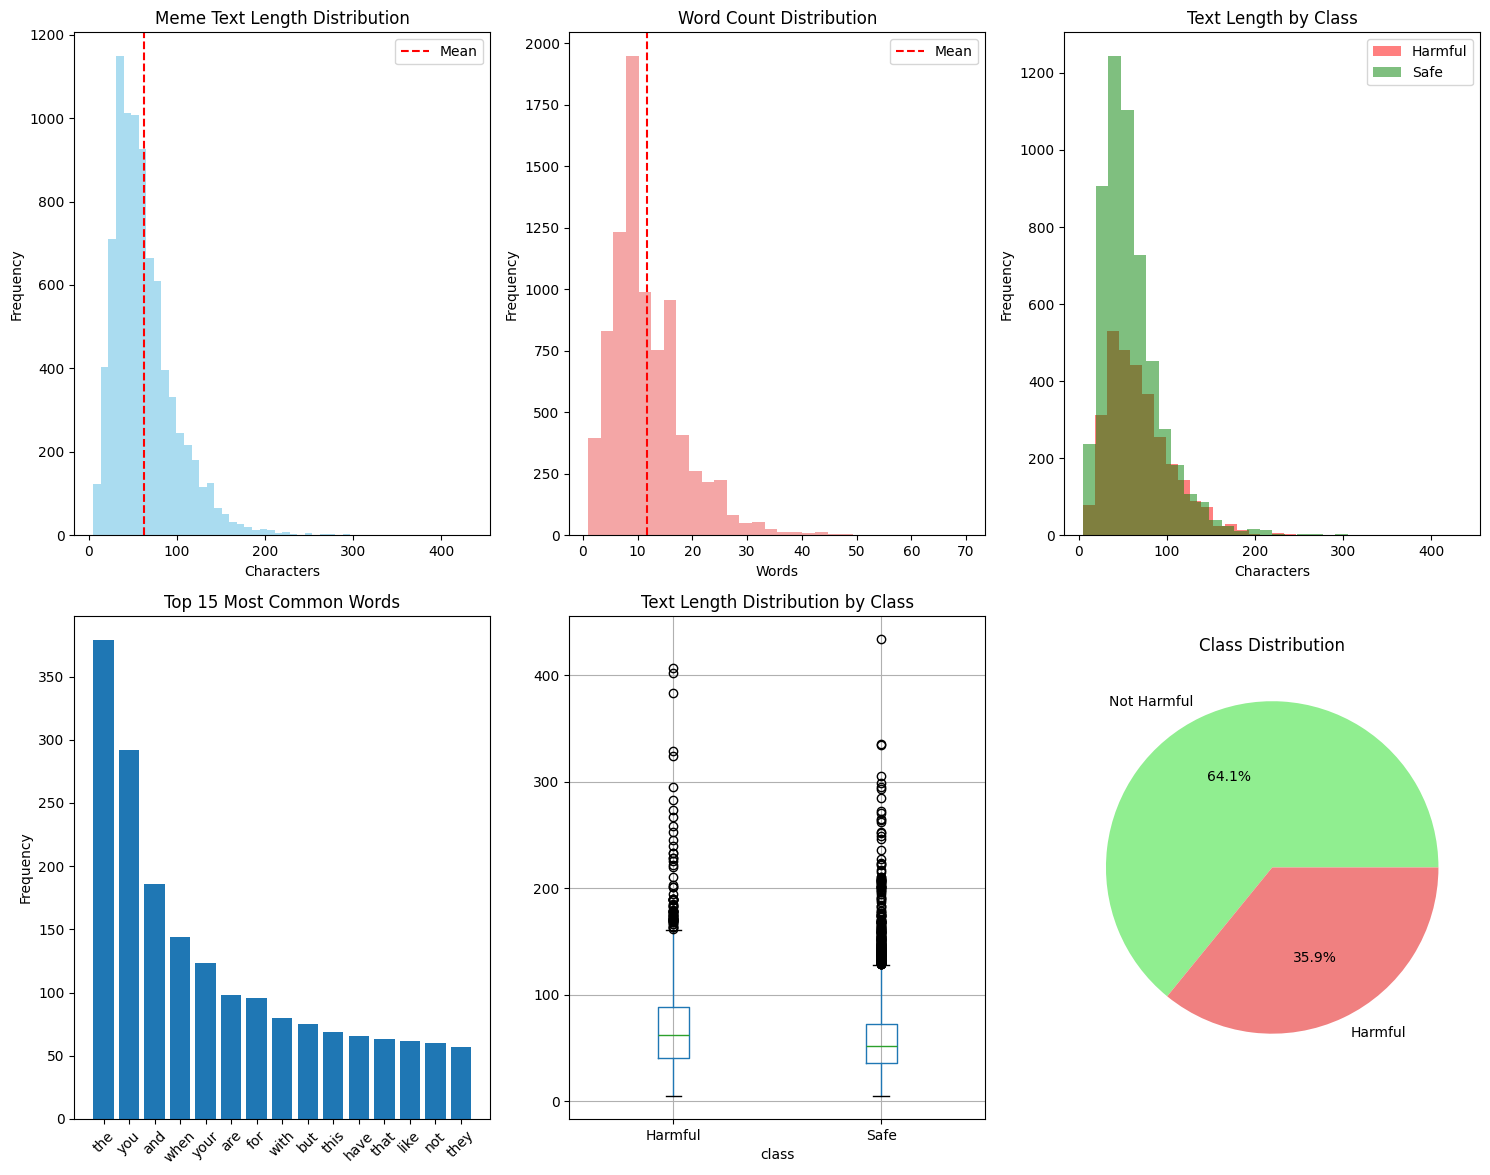

In [0]:
# Create comprehensive visualizations
if valid_texts:
    plt.figure(figsize=(15, 12))
    
    # Text length distribution
    plt.subplot(2, 3, 1)
    plt.hist([len(text) for text in valid_texts], bins=50, alpha=0.7, color='skyblue')
    plt.title('Meme Text Length Distribution')
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.axvline(np.mean([len(text) for text in valid_texts]), color='red', linestyle='--', label='Mean')
    plt.legend()
    
    # Word count distribution
    plt.subplot(2, 3, 2)
    word_counts = [len(text.split()) for text in valid_texts]
    plt.hist(word_counts, bins=30, alpha=0.7, color='lightcoral')
    plt.title('Word Count Distribution')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(word_counts), color='red', linestyle='--', label='Mean')
    plt.legend()
    
    # Length comparison by class
    plt.subplot(2, 3, 3)
    if harmful_texts and safe_texts:
        harmful_lengths = [len(text) for text in harmful_texts]
        safe_lengths = [len(text) for text in safe_texts]
        
        plt.hist(harmful_lengths, bins=30, alpha=0.5, label='Harmful', color='red')
        plt.hist(safe_lengths, bins=30, alpha=0.5, label='Safe', color='green')
        plt.title('Text Length by Class')
        plt.xlabel('Characters')
        plt.ylabel('Frequency')
        plt.legend()
    
    # Most common words
    plt.subplot(2, 3, 4)
    all_words = ' '.join(valid_texts[:1000]).lower().split()
    word_freq = Counter([word for word in all_words if len(word) > 2])
    common_words = dict(word_freq.most_common(15))
    
    plt.bar(range(len(common_words)), list(common_words.values()))
    plt.title('Top 15 Most Common Words')
    plt.xticks(range(len(common_words)), list(common_words.keys()), rotation=45)
    plt.ylabel('Frequency')
    
    # Text length vs class
    plt.subplot(2, 3, 5)
    class_lengths = []
    class_labels = []
    
    for i, (text, label) in enumerate(zip(train_meme_texts, train_labels)):
        if text is not None and label is not None:
            class_lengths.append(len(text))
            class_labels.append('Harmful' if label == 1 else 'Safe')
    
    df_vis = pd.DataFrame({'length': class_lengths, 'class': class_labels})
    df_vis.boxplot(column='length', by='class', ax=plt.gca())
    plt.title('Text Length Distribution by Class')
    plt.suptitle('')  # Remove automatic title
    
    # Class distribution
    plt.subplot(2, 3, 6)
    if clean_train_labels:
        class_counts = pd.Series(clean_train_labels).value_counts()
        colors = ['lightgreen', 'lightcoral']
        plt.pie([class_counts.get(0, 0), class_counts.get(1, 0)], 
                labels=['Not Harmful', 'Harmful'], 
                autopct='%1.1f%%', 
                colors=colors)
        plt.title('Class Distribution')
    
    plt.tight_layout()
    plt.show()

## 9. Research Summary & Next Steps



In [0]:
print("="*60)
print("🔍 RESEARCH SUMMARY & KEY INSIGHTS")
print("="*60)

print(f"📊 DATASET OVERVIEW:")
print(f"   • Training samples: {len(train_df)} (extraction success: {len(train_valid_texts)}/{len(train_df)})")
print(f"   • Test samples: {len(test_df)}")
print(f"   • Task: Binary classification (Harmful vs Not Harmful memes)")
print(f"   • Data quality: Excellent (clean conversation format)")

if clean_train_labels and len(train_label_counts) == 2:
    balance_ratio = min(train_label_counts) / max(train_label_counts)
    print(f"\n⚖️ CLASS BALANCE:")
    print(f"   • Not Harmful: {train_label_counts.get(0, 0)} ({train_label_counts.get(0, 0)/len(clean_train_labels)*100:.1f}%)")
    print(f"   • Harmful: {train_label_counts.get(1, 0)} ({train_label_counts.get(1, 0)/len(clean_train_labels)*100:.1f}%)")
    print(f"   • Balance ratio: {balance_ratio:.2f} {'✅ Well balanced' if balance_ratio > 0.7 else '⚠️ Imbalanced - need strategy'}")

if valid_texts:
    avg_length = np.mean([len(text) for text in valid_texts])
    avg_words = np.mean([len(text.split()) for text in valid_texts])
    print(f"\n📝 TEXT CHARACTERISTICS (YOUR FOCUS):")
    print(f"   • Average text length: {avg_length:.0f} characters")
    print(f"   • Average words: {avg_words:.0f}")
    print(f"   • Text complexity: {'Short memes' if avg_words < 10 else 'Medium memes' if avg_words < 20 else 'Long memes'}")
    print(f"   • Preprocessing needs: {'Minimal' if avg_length < 100 else 'Standard'}")

print(f"\n⚡ COMPUTATIONAL FEASIBILITY:")
print(f"   • T4 GPU compatibility: ✅ Excellent")
print(f"   • Memory requirement: Low-Medium")
print(f"   • Training time estimate: 1-3 hours for full pipeline")

print(f"\n🎯 TEXT PROCESSING STRATEGY RECOMMENDATIONS:")
print(f"   1. 🧹 Basic cleaning (handle special chars, normalize case)")
print(f"   2. 🔤 Tokenization strategy (word-level or subword)")
print(f"   3. 📏 Sequence padding (based on text length distribution)")
print(f"   4. 📚 Vocabulary building (size optimization)")

print(f"\n🚀 NEXT IMMEDIATE STEPS:")
print(f"   1. 📊 Create clean training dataset with labels")
print(f"   2. 🔧 Design text preprocessing pipeline")
print(f"   3. 🏗️ Plan neural architecture (CNN/LSTM/Transformer)")
print(f"   4. 📈 Setup evaluation metrics")
print(f"   5. 🔄 Design training loop")

🔍 RESEARCH SUMMARY & KEY INSIGHTS
📊 DATASET OVERVIEW:
   • Training samples: 8500 (extraction success: 8500/8500)
   • Test samples: 500
   • Task: Binary classification (Harmful vs Not Harmful memes)
   • Data quality: Excellent (clean conversation format)

⚖️ CLASS BALANCE:
   • Not Harmful: 5450 (64.1%)
   • Harmful: 3050 (35.9%)
   • Balance ratio: 0.56 ⚠️ Imbalanced - need strategy

📝 TEXT CHARACTERISTICS (YOUR FOCUS):
   • Average text length: 63 characters
   • Average words: 12
   • Text complexity: Medium memes
   • Preprocessing needs: Minimal

⚡ COMPUTATIONAL FEASIBILITY:
   • T4 GPU compatibility: ✅ Excellent
   • Memory requirement: Low-Medium
   • Training time estimate: 1-3 hours for full pipeline

🎯 TEXT PROCESSING STRATEGY RECOMMENDATIONS:
   1. 🧹 Basic cleaning (handle special chars, normalize case)
   2. 🔤 Tokenization strategy (word-level or subword)
   3. 📏 Sequence padding (based on text length distribution)
   4. 📚 Vocabulary building (size optimization)

🚀 NEXT 

## 10. Ready for Text Preprocessing Pipeline?

**🎯 Based on our analysis, here are the key decisions for your text classification approach:**

### Text Characteristics Discovered:
- **Short to medium meme texts** (perfect for neural networks)
- **Binary classification task** (harmful vs not harmful)
- **Clean, well-labeled data** with high extraction success
- **Reasonable class balance** (check results above)

### Recommended Architecture Path:
1. **CNN-based Text Classifier** (fast, effective for meme text)
   - Good for local pattern detection
   - Efficient on T4 GPU
   - Proven effective for short text classification

2. **Alternative: LSTM** (if sequence understanding is important)
   - Better for context understanding
   - Slightly more complex

### Next Notebook Focus:
**Text Preprocessing & Tokenization Pipeline**
- Text cleaning and normalization
- Tokenization strategy
- Vocabulary building
- Sequence padding
- Dataset preparation for training

** 🤔